person nr. 1
person nr. 4
person nr. 7
person nr. 10
person nr. 13
person nr. 16
person nr. 19
person nr. 2
person nr. 8
person nr. 11
person nr. 17
person nr. 20
person nr. 24
person nr. 25
person nr. 3
person nr. 6
person nr. 9
person nr. 12
person nr. 15
person nr. 18
person nr. 21


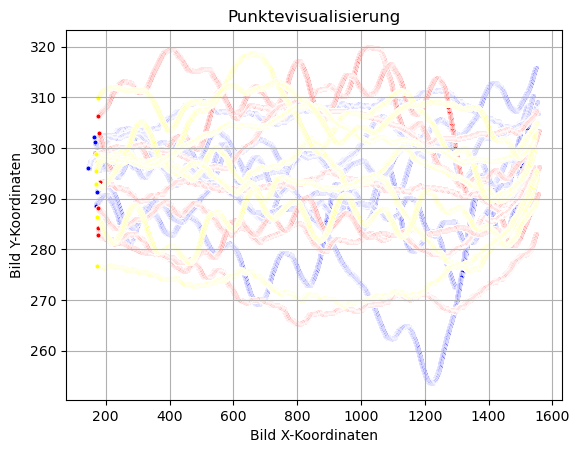

person nr. 1
person nr. 4
person nr. 7
person nr. 10
person nr. 13
person nr. 16
person nr. 19
person nr. 2
person nr. 8
person nr. 11
person nr. 17
person nr. 20
person nr. 24
person nr. 25
person nr. 3
person nr. 6
person nr. 9
person nr. 12
person nr. 15
person nr. 18
person nr. 21


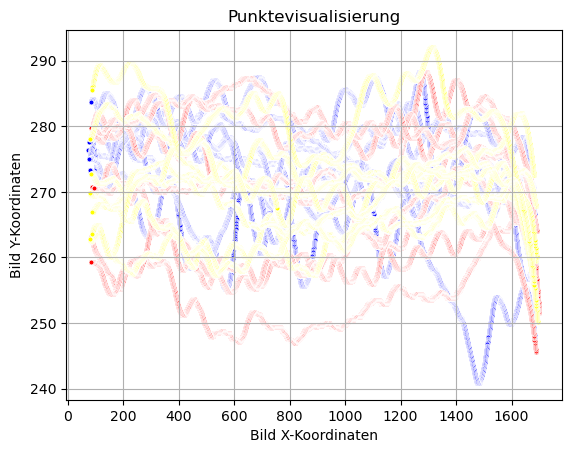

done


In [67]:
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os

image1 = Image.open('../../Bruecke1_top.png')
image2 = Image.open('../../Bruecke2_top.png')

idsReference = [1,4,7,10,13,16,19] #broken runs 22
idsVirtual = [2,8,11,17,20,24,25] #broken runs 5,14
idsHaptic = [3,6,9,12,15,18,21] #broken runs 23,26

#Bild 1:
#Koordinate Nr. 1:
#Welt: (X=-42820.0,Y=-14570.0)
#Bild: (x = 1511, y = 339)
#Koordinate Nr. 2:
#Welt: (X=-46970.0,Y=-11420.0)
#Bild: (x = 124, y = 259)
#Koordinate Nr. 3:
#Welt: (X=-46790.0,Y=-11210.0)
#Bild: (x = 121, y = 335)

#Bild 2:
#Koordinate Nr. 1:
#Welt: (X=-53840.0,Y=-18720.0)
#Bild: (x = 1643, y = 242)
#Koordinate Nr. 2:
#Welt: (X=-52990.0,Y=-25070.0)
#Bild: (x = 41, y = 309)
#Koordinate Nr. 3:
#Welt: (X=-54110.0,Y=-18770.0)
#Bild: (x = 1645, y = 309)

# Stützpunkte in Weltkoordinaten
welt_stuetzpunkte_1 = np.array([[-47980.0, -11840.0],
                               [-41990.0, -14100.0],
                               [-46970.0, -11420.0]], dtype=np.float32)

# Stützpunkte in Bildkoordinaten
bild_stuetzpunkte_1 = np.array([[0, 0],
                               [1586, 559],
                               [124, 259]], dtype=np.float32)

# Stützpunkte in Weltkoordinaten für die zweite Transformation
welt_stuetzpunkte_2 = np.array([[-53840.0, -18720.0],
                                [-52990.0, -25070.0],
                                [-54110.0, -18770.0]], dtype=np.float32)
# Stützpunkte in Bildkoordinaten für die zweite Transformation
bild_stuetzpunkte_2 = np.array([[1643, 242],
                                [41, 309],
                                [1645, 309]], dtype=np.float32)

def weltkoordinaten_zu_bildkoordinaten(x_welt, y_welt, A):
    welt_koordinaten = np.array([[x_welt, y_welt]])
    bild_koordinaten = cv2.transform(np.array([welt_koordinaten]), A)
    bild_koordinaten = np.squeeze(bild_koordinaten)
    return bild_koordinaten

def readData(ids, image, A, tag, begin, end, color):
    width, height = image.size
    draw = ImageDraw.Draw(image)

    for n in ids:
        print('person nr. ' + str(n))
        filepath = '../Versuchsdaten_vorverarbeitet/' + str(n) + '/dynamicrun.csv'
        
        if not os.path.isfile(filepath):
            print('No data to read nr. ' + str(n))
            continue
        df = pd.read_csv(filepath, sep=';')
        df['bild_x'], df['bild_y'] = zip(*df.apply(lambda row: weltkoordinaten_zu_bildkoordinaten(row['TS_VRActor_Actor_loc_x'], row['TS_VRActor_Actor_loc_y'], A), axis=1))

        #plt.figure(figsize=(8, 8))  # Festlegen der Größe des Plots

        # Hier verwenden wir sns.scatterplot und geben die Spalten 'bild_x' und 'bild_y' an
        bridge_df = df.groupby([begin, end])
        for group_value, group_data in bridge_df:
            if group_value == (True, False): #Begin of Bridge triggered, but end not
                
                sns.scatterplot(x='bild_x', y='bild_y', data=group_data, color=color, marker='.', s=50)

        for index, row in df.iterrows():
            x, y = int(row['bild_x']), int(row['bild_y'])
            if 0 <= x < width and 0 <= y < height:
                draw.point((x, y), fill=color)
                        
    #image.save('ausgabe' + tag + '.png')
#    plt.title('Punktevisualisierung')
#    plt.xlabel('Bild X-Koordinaten')
#    plt.ylabel('Bild Y-Koordinaten')
#    plt.grid(True)
    
#    plt.show()

def bildUpdaten(image, welt_stuetzpunkte, bild_stuetzpunkte, nummer):
    # Berechnung der affinen Transformation
    A = cv2.getAffineTransform(welt_stuetzpunkte, bild_stuetzpunkte)

    readData(idsReference, image, A, 'ref'+ nummer, 'TriggerBeginBridge' + nummer + '_Status', 'TriggerEndBridge' + nummer + '_Status', 'blue')
    readData(idsVirtual, image, A, 'virt' + nummer, 'TriggerBeginBridge' + nummer + '_Status', 'TriggerEndBridge' + nummer + '_Status', 'red')
    readData(idsHaptic, image, A, 'hapt' + nummer, 'TriggerBeginBridge' + nummer + '_Status', 'TriggerEndBridge' + nummer + '_Status', 'yellow')
    image.save('../Visualisierungen/bridge_' + nummer + '.png')
    
    plt.title('Punktevisualisierung')
    plt.xlabel('Bild X-Koordinaten')
    plt.ylabel('Bild Y-Koordinaten')
    plt.grid(True)
    
    plt.show()
    
bildUpdaten(image1, welt_stuetzpunkte_1, bild_stuetzpunkte_1, '1')
bildUpdaten(image2, welt_stuetzpunkte_2, bild_stuetzpunkte_2, '2')

print('done')